# Stamp Detection using Computer Vision and Python

We will use OpenCV to identify the number of stamps in a picture.

# Background

A friend of mine reach out and asked me whether I could write a program to detect the number of [Rubber stamps](https://en.wikipedia.org/wiki/Rubber_stamp) in an image. Apparently, these invoice receipts will be categorized based on the number of stamps on them. Initially, I thought of building a Deep Learning Segmentation model, but soon I realized that it is not worth the effort. The images are generated in a controlled environment so few  computer vision algorithms should do the trick. To illustrate the computer vision algorithms used in detecting the stamps, I will be using a sample image downloaded from Google as the original image is company property. The goal is to identify two stamps in the sample image.

![stamp detection gif](https://raw.githubusercontent.com/6aravind/tidbits/main/assets/gifs/stamp%20detection.gif)

# Solution

High level solution steps are:

1. Read the image.
2. Blur & detect the edges.
3. Find all contours and remove the smaller contours.
4. Fill the area inside contours & Close the blobs.
5. Filter the stamps.

Before we start let us import the necessary packages.

In [2]:
## Libraries

from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Read the image

Read the color image using [imread](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) function. To display the image we will use Matplotlib. Matplotlib expects the color image channels to be of the order RGB but Opencv reads the image as BGR so we will write a helper function for the conversion. 

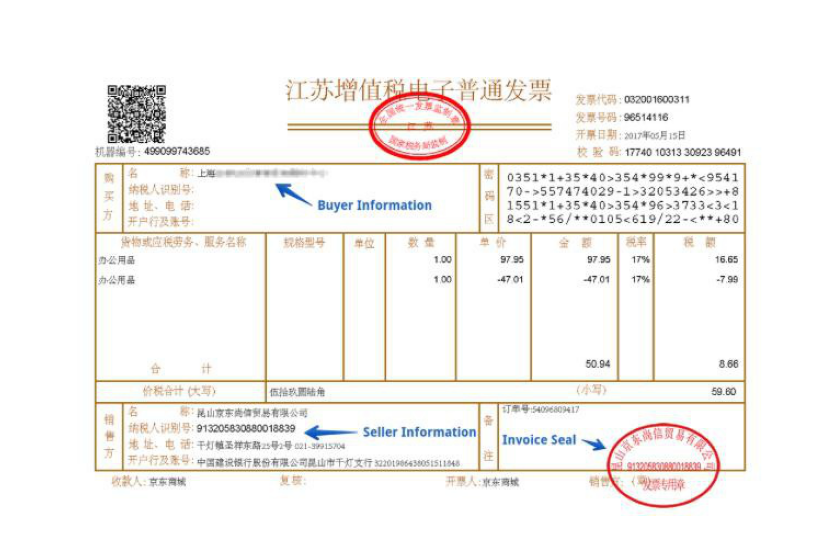

In [3]:
## Read and display the image

imgFile = "stamp_detection.jpeg"
img = cv2.imread(imgFile)

def imshow(img, showAxis = False, size=(20,10)):
    plt.figure(figsize=size)
    if not showAxis: plt.axis('off')
    if len(img.shape) == 3: plt.imshow(img[:,:,::-1])
    else: plt.imshow(img, cmap='gray')
    
imshow(img)

## 2. Blur & detect the edges

First, we need to convert the image to grayscale using [cvtColor](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) function. Then, we will use [bilateralFilter](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed) to reduce noise in the image. Bilateral filter is preferred over Gaussian because it preserves the edges much better. Finally, we will use [canny](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html) edge detector to threshold the image and detect edges. The normal canny edge detector requires two threshold parameters which is hard to tune so we will use the one from [Zero-parameter, automatic Canny edge detection with Python and OpenCV](https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/)

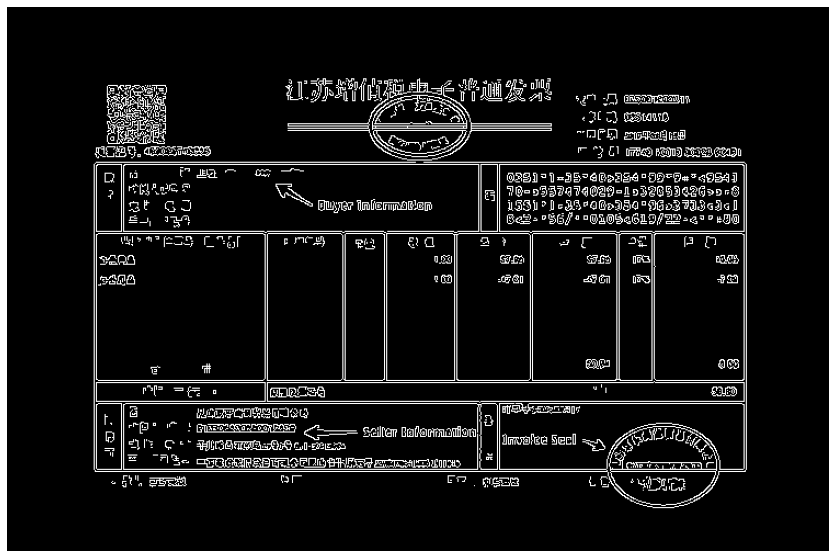

In [4]:
## Blur & detect the edges

# Convert to Grayscale
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

# Blur to remove noise
blur = cv2.bilateralFilter(gray.copy(), 15, 15, 15 )

# Find edges using canny edge detector
def auto_canny(grayim, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(grayim)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(grayim, lower, upper)
    # return the edged image
    return edged

# Find the edges and display the image
edged = auto_canny(blur)
imshow(edged)

## 3. Find all contours and remove the smaller contours

[findContours](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a) function can find all contours in the image. The outer most contours are good enough for our use case so we will use the retrieval mode **RETR_EXTERNAL**. **CHAIN_APPROX_NONE** mode is preferred as we don't want to lose any point on the contour due to approximation. To remove the unwanted smaller contours, we can filter the contours by area.

In [10]:
## Find Contours

# detect the contours on the binary image
contours, _ = cv2.findContours(image=edged.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
print(f'Total nr of contours found: {len(contours)}')

# Sort Contours by Area and get topN
topN = 10
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)                     
sorted_contours = sorted_contours[:topN]

Total nr of contours found: 408


## 4. Fill the area inside contours & Close the blobs

Instead of working on the original binary image, we will draw the top contours on a image with black background and use this as base. Any disconnect in the contours are easier to identify when fill the area inside the contours using [drawContours](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc) function.

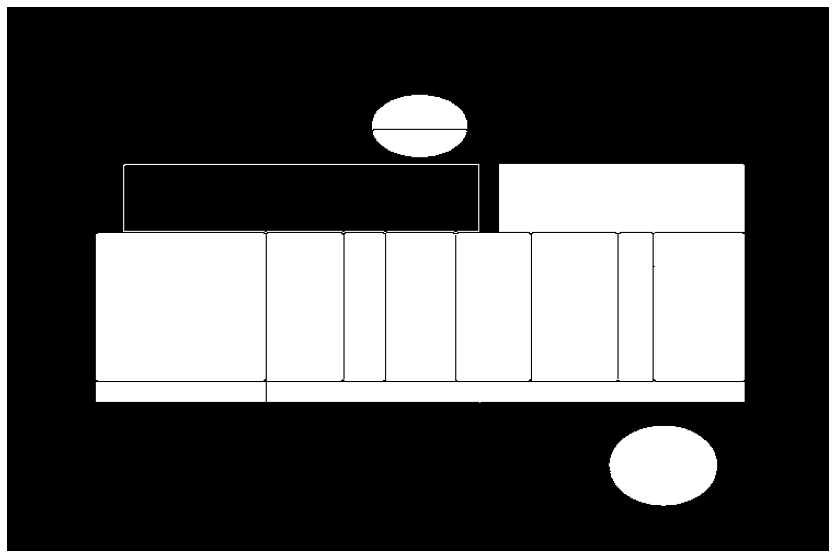

In [7]:
##  Fill the area inside contours
filteredCircle = np.zeros((img.shape[:2]), dtype =np.uint8)
cv2.drawContours(image=filteredCircle, contours=sorted_contours, contourIdx=-1, color=(255, 255, 255), thickness=cv2.FILLED)
imshow(filteredCircle)

As suspected, the top stamp has a thin black line passing through it. We need to close this blob so that the top stamp is considered as one contour instead of two different ones. [Morphological Closing](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga67493776e3ad1a3df63883829375201f) operation is perfect for achieving this.

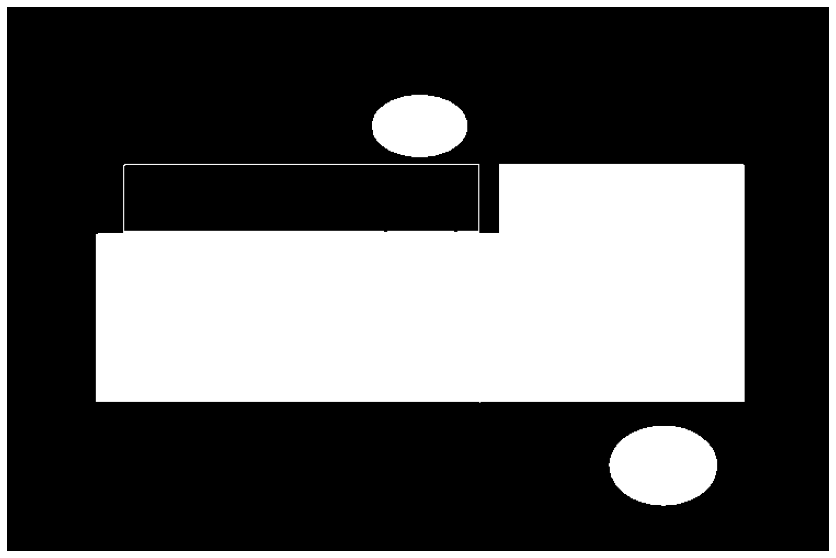

In [11]:
## Close Blobs

kernel = np.ones((3,3),np.uint8)
closedCircle = cv2.morphologyEx(filteredCircle, cv2.MORPH_CLOSE, kernel, iterations=1)
imshow(closedCircle)

## 5. Filter the stamps

To isolate the stamp contours, we can identify all the contours from the latest binary image and filter for contours with more than 5 points as the stamp is an ellipse. 

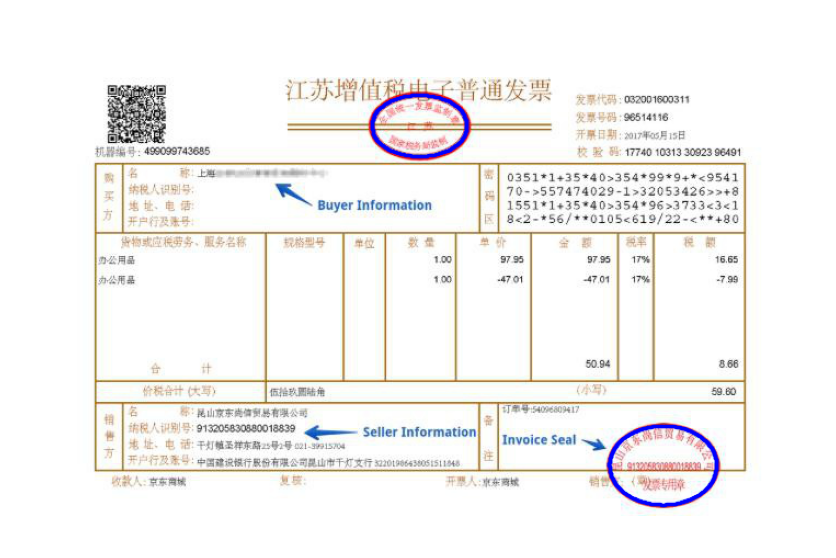

In [12]:
## Filter Stamps

# Find contours from the processed binary image
filteredContours, _ = cv2.findContours(image=closedCircle.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

# Identify only contours with more than 5 points
circleContours = []
for index, contour in enumerate(filteredContours):
    perimeter = cv2.arcLength(contour,True)
    approxPoints = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    if len(approxPoints) > 5: 
        circleContours.append(contour)

# Display the identified stamps
out = img.copy()
cv2.drawContours(image=out, contours=circleContours, contourIdx=-1, color=(255,0, 0), thickness=2, lineType=cv2.LINE_AA)
imshow(out)

# Bonus - Highlight the identified stamps

For demo of this program, wouldn't it be cool if we can highlight only the stamped area of the image? Since we agree that it is indeed cool, let us see how we can achieve that. The steps involved are:

1. Duplicate the original image and blur the entire image.
2. Loop through the blurred image and for the points on or inside the image (using [pointPolygonTest](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga1a539e8db2135af2566103705d7a5722) to check) we replace it with pixel values from the output image. We are using pixel values from the output image because we need the blue lines drawn over the stamps.



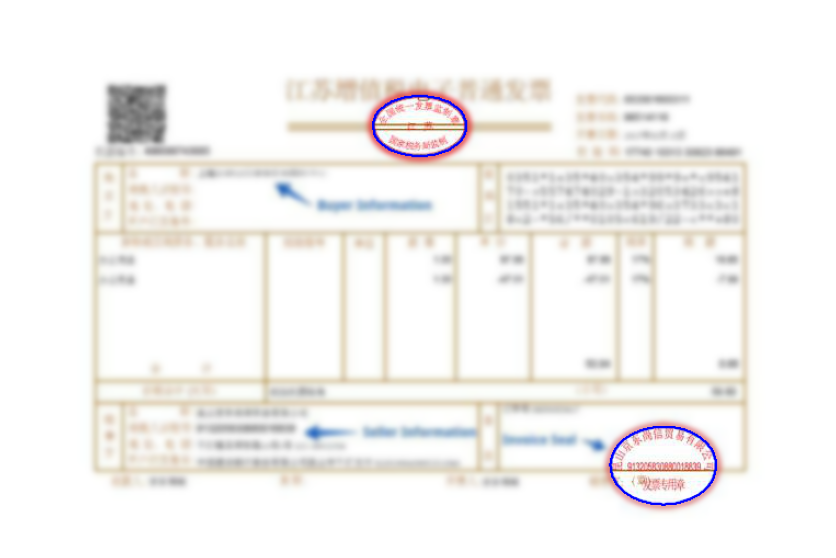

In [13]:
# Highlight the stamped region

# Import
from itertools import product

# Blur the image
highlight_blur = cv2.GaussianBlur(img.copy(), (15,15),0)

# Loop through every point in the image
for y, x in product(range(img.shape[0]), range(img.shape[1])):
    # Loop through all the contours
    for contour in circleContours:
        # Check if the point is on or inside the contour
        if cv2.pointPolygonTest(contour, [x, y], False) >= 0.0:
            # Replace the image with the output image
            highlight_blur[y, x, :] = out[y, x, :]

imshow(highlight_blur)

# Conclusion

Yep, that's it for this post. You can access this notebook from [here]().